In [2]:
import findspark
findspark.init()

In [3]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Data Classification').getOrCreate()

## EDA

In [4]:
import pyspark.sql.functions as f

### Importing Data

In [18]:
df = spark.read.option("header", True).option("inferSchema", True).option("delimiter",",").csv("train.csv")
df.limit(5).toPandas()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [19]:
df = df.withColumnRenamed("income_>50K", "target")

In [20]:
df.groupBy(f.col("education"),f.col("educational-num")).count().orderBy("educational-num").show()

+------------+---------------+-----+
|   education|educational-num|count|
+------------+---------------+-----+
|   Preschool|              1|   76|
|     1st-4th|              2|  223|
|     5th-6th|              3|  468|
|     7th-8th|              4|  862|
|         9th|              5|  684|
|        10th|              6| 1250|
|        11th|              7| 1647|
|        12th|              8|  587|
|     HS-grad|              9|14197|
|Some-college|             10| 9790|
|   Assoc-voc|             11| 1831|
|  Assoc-acdm|             12| 1447|
|   Bachelors|             13| 7219|
|     Masters|             14| 2392|
| Prof-school|             15|  748|
|   Doctorate|             16|  536|
+------------+---------------+-----+



In [21]:
cols_to_drop = []
cols_to_drop.append("education")

In [22]:
df.select("age","educational-num", "capital-gain","capital-loss","hours-per-week").summary().show()

+-------+------------------+------------------+------------------+------------------+-----------------+
|summary|               age|   educational-num|      capital-gain|      capital-loss|   hours-per-week|
+-------+------------------+------------------+------------------+------------------+-----------------+
|  count|             43957|             43957|             43957|             43957|            43957|
|   mean| 38.61714857701845|10.074117887935937|1093.5597970744136| 88.24649088882317|40.40769388265805|
| stddev|13.734400969233434| 2.575091755705552| 7570.536063135791|404.58841023557716|12.40030286325264|
|    min|                17|                 1|                 0|                 0|                1|
|    25%|                28|                 9|                 0|                 0|               40|
|    50%|                37|                10|                 0|                 0|               40|
|    75%|                48|                12|                 

In [23]:
df.filter(f.col("capital-gain")==0).count()

40330

In [24]:
df.filter(f.col("capital-loss") ==0).count()

41884

In [25]:
cols_to_drop.append("capital-gain")
cols_to_drop.append("capital-loss")

In [26]:
df.select("fnlwgt").distinct().count()

26646

In [27]:
cols_to_drop.append("fnlwgt")

### Plotting categorical columns

In [29]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]

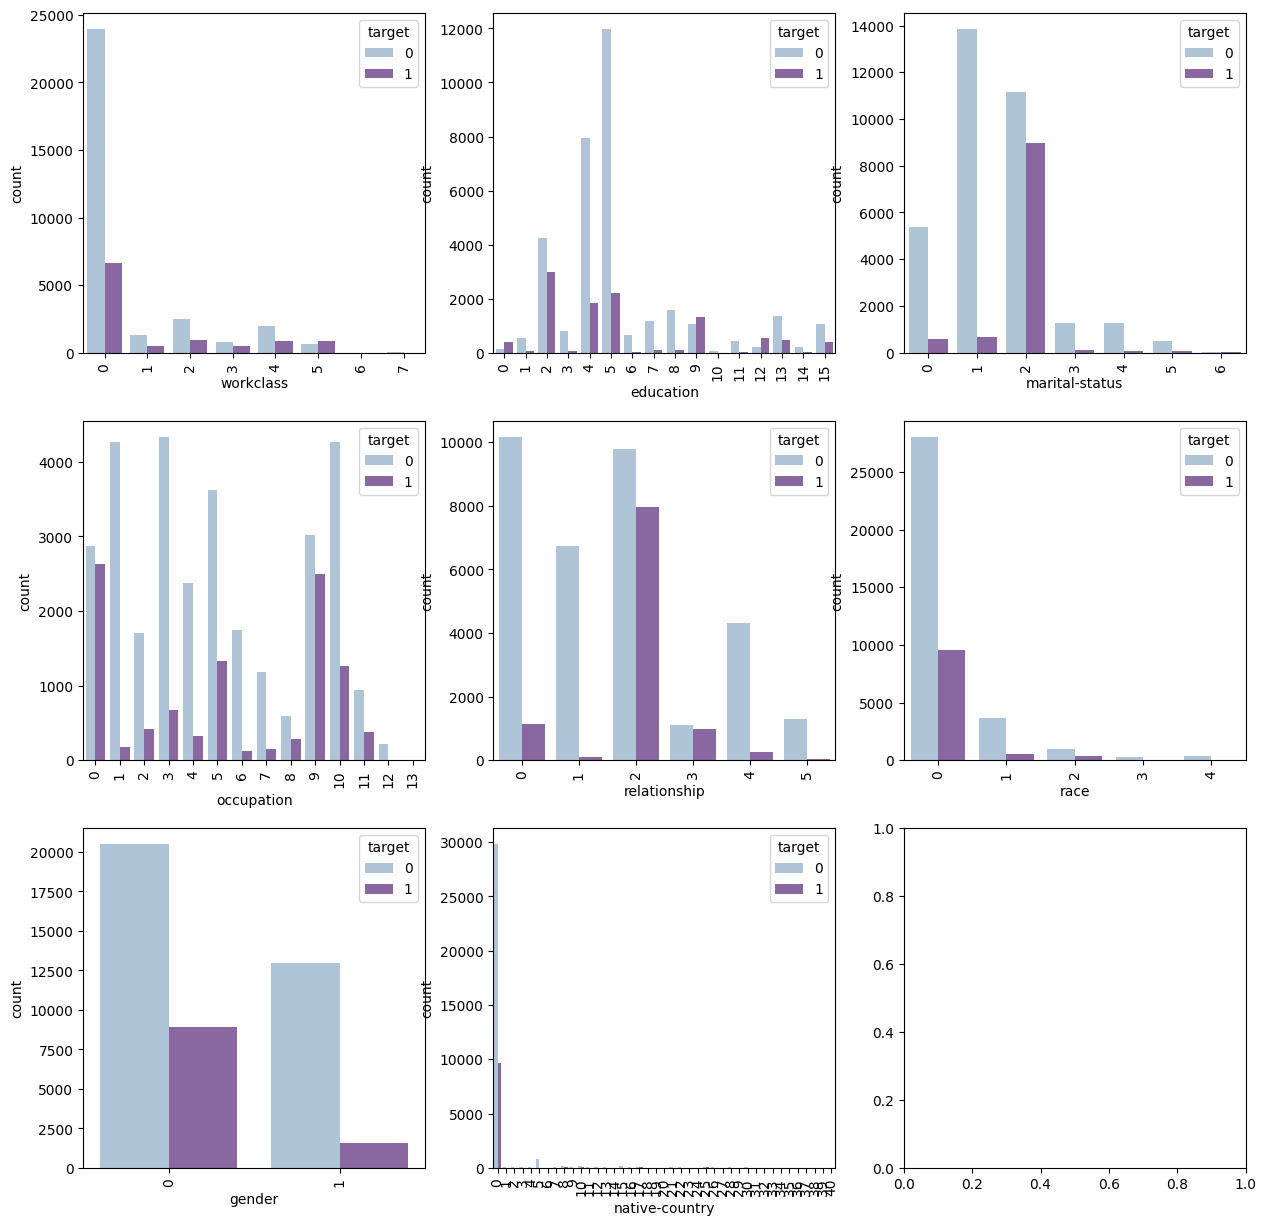

In [31]:
df1 = df.toPandas()
fig, ax = plt.subplots(3,3,figsize= (15,15))
for i, subplots in zip(cat_cols, ax.flatten()):
    sns.countplot(data = df1, x=df1[i], hue="target", ax = subplots, palette="BuPu")
    subplots.set_xticklabels(subplots.get_xticks(), rotation = 90)
plt.show()

In [17]:
df.groupBy("native-country").count().sort(f.col("count").desc()).show()

+------------------+-----+
|    native-country|count|
+------------------+-----+
|     United-States|39429|
|            Mexico|  880|
|              null|  763|
|       Philippines|  273|
|           Germany|  188|
|       Puerto-Rico|  167|
|            Canada|  158|
|       El-Salvador|  145|
|             India|  134|
|              Cuba|  124|
|             China|  113|
|           England|  109|
|             South|  105|
|           Jamaica|   97|
|Dominican-Republic|   97|
|             Italy|   94|
|             Japan|   83|
|         Guatemala|   79|
|           Vietnam|   77|
|          Columbia|   75|
+------------------+-----+
only showing top 20 rows



In [18]:
df.groupBy("race").count().sort(f.col("count").desc()).show()

+------------------+-----+
|              race|count|
+------------------+-----+
|             White|37572|
|             Black| 4218|
|Asian-Pac-Islander| 1373|
|Amer-Indian-Eskimo|  421|
|             Other|  373|
+------------------+-----+



### Plotting Numerical Columns

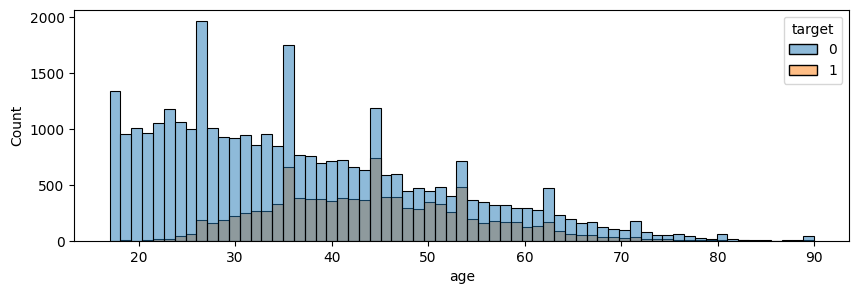

In [19]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=df1, x='age', hue='target')
plt.show()

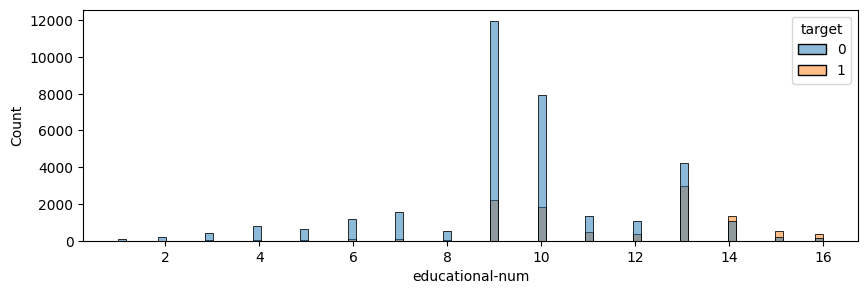

In [20]:
fig, ax = plt.subplots(figsize=(10,3))
sns.histplot(data=df1, x='educational-num', hue='target')
plt.show()

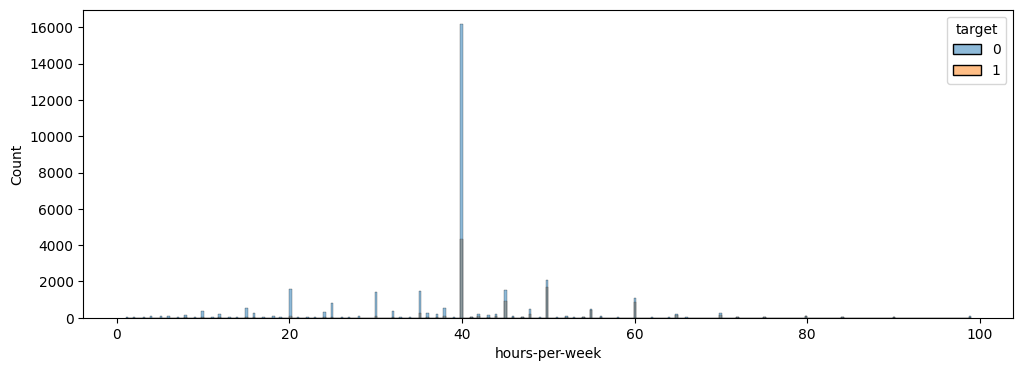

In [21]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=df1, x='hours-per-week', hue='target')
plt.show()

In [32]:
for i in cols_to_drop:
    del df1[i]

In [33]:
df = df.drop(*cols_to_drop)
cat_cols.remove("education")

In [34]:
df1.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,target
0,67,Private,16,Divorced,Exec-managerial,Not-in-family,White,Male,60,United-States,1
1,17,Private,8,Never-married,Other-service,Own-child,White,Male,15,United-States,0
2,31,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,United-States,1
3,58,State-gov,4,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,0
4,25,State-gov,10,Never-married,Other-service,Not-in-family,Black,Male,40,United-States,0


### Correlation Check

In [35]:
df_num = df.select("age", "educational-num", "hours-per-week").toPandas()
corr_mat = df_num.corr().abs()
corr_mat.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,age,educational-num,hours-per-week
age,1.000000,0.034711,0.070949
educational-num,0.034711,1.000000,0.145670
hours-per-week,0.070949,0.145670,1.000000


### Variance Check

In [36]:
from sklearn.feature_selection import VarianceThreshold
threshold = 0.05
varThreshold = VarianceThreshold(threshold=threshold)
varThreshold.fit(df_num)

VarianceThreshold(threshold=0.05)

In [37]:
low_vars = [column for column in df_num.columns if column not in df_num.columns[varThreshold.get_support()]]
low_vars

[]

### Imputing missing data

In [38]:
df.select([f.count(f.when(f.col(c).contains('None') | f.col(c).contains('NULL') | (f.col(c) == "") | f.col(c).isNull() | f.isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---------+---------------+--------------+----------+------------+----+------+--------------+--------------+------+
|age|workclass|educational-num|marital-status|occupation|relationship|race|gender|hours-per-week|native-country|target|
+---+---------+---------------+--------------+----------+------------+----+------+--------------+--------------+------+
|  0|     2498|              0|             0|      2506|           0|   0|     0|             0|           763|     0|
+---+---------+---------------+--------------+----------+------------+----+------+--------------+--------------+------+



In [39]:
# Imputing the missing data in categorical columns using "mode" method

work_mode = df.groupBy("workclass").count().orderBy(f.col("count").desc()).first()[0]
occu_mode = df.groupBy("occupation").count().orderBy(f.col("count").desc()).first()[0]
country_mode = df.groupBy("native-country").count().orderBy(f.col("count").desc()).first()[0]

In [40]:
df = df.fillna({"workclass": work_mode, "occupation": occu_mode, "native-country":country_mode})

### Balancing data by targets

In [41]:
df.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1|10518|
|     0|33439|
+------+-----+



In [42]:
df = df.sampleBy(f.col("target"), fractions = {0:0.315 , 1:1}, seed=0)

df.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1|10518|
|     0|10564|
+------+-----+



### String Indexing Categorical Columns

In [71]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

num_cols = [i for i in df1.columns if i not in cat_cols]
num_cols.remove("target")
ind_op_cols = [i+"_ind" for i in cat_cols]
ohe_op_cols = [i+"_ohe" for i in cat_cols]

In [84]:
indexer = StringIndexer(inputCols= cat_cols, outputCols=ind_op_cols)
#inputs = indexer.getOutputCols()
encoder = OneHotEncoder(inputCols = ind_op_cols, outputCols = ohe_op_cols, dropLast = False)
assembler = VectorAssembler(inputCols = ohe_op_cols+num_cols, outputCol="features")
ohe_pipe = Pipeline(stages=[indexer, encoder, assembler])
pipe_model = ohe_pipe.fit(df)
idf = pipe_model.transform(df)


In [85]:
training_data = idf.select("features", "target")

In [83]:
training_data.show(truncate=False)

+--------------------------------------------------------------------------------+------+
|features                                                                        |target|
+--------------------------------------------------------------------------------+------+
|(85,[0,10,15,30,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.0,16.0,60.0])|1     |
|(85,[0,8,15,29,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,31.0,13.0,40.0]) |1     |
|(85,[4,9,19,31,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0,9.0,40.0])  |0     |
|(85,[0,8,21,33,35,41,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,70.0,5.0,40.0])  |0     |
|(85,[0,8,15,29,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0,9.0,45.0])  |1     |
|(85,[0,9,15,31,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,10.0,25.0]) |0     |
|(85,[0,11,26,30,35,41,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,76.0,4.0,12.0]) |0     |
|(85,[0,8,22,29,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,30.0,6.0,55.0])  |0     |
|(85,[5,8,

## Model Training

In [47]:
training_data = training_data.withColumnRenamed("target", "label")

In [48]:
train, test = training_data.randomSplit([0.7,0.3], seed=100)
print("There are %d Training samples and %d Test samples."%(train.count(), test.count()))

There are 14765 Training samples and 6317 Test samples.


### Logistic Regression

In [56]:
from pyspark.ml.classification import LogisticRegression


In [58]:
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train)

In [59]:
predictions_lr = lr_model.transform(test)
prob_lr = predictions_lr.select("probability", 'prediction', 'label')
prob_lr.show(truncate=False)

+----------------------------------------+----------+-----+
|probability                             |prediction|label|
+----------------------------------------+----------+-----+
|[0.1574652611441756,0.8425347388558244] |1.0       |0    |
|[0.09728479060324201,0.902715209396758] |1.0       |1    |
|[0.5409203871366638,0.4590796128633362] |0.0       |0    |
|[0.34432438488523087,0.6556756151147691]|1.0       |0    |
|[0.31394917728040406,0.6860508227195959]|1.0       |1    |
|[0.09446103495803317,0.9055389650419668]|1.0       |0    |
|[0.37776567150815166,0.6222343284918483]|1.0       |0    |
|[0.14678181328974596,0.8532181867102541]|1.0       |1    |
|[0.07794948225156616,0.9220505177484338]|1.0       |1    |
|[0.329767050063766,0.6702329499362341]  |1.0       |1    |
|[0.29175894326236107,0.7082410567376389]|1.0       |0    |
|[0.23109954951913705,0.768900450480863] |1.0       |1    |
|[0.14274856003526376,0.8572514399647362]|1.0       |0    |
|[0.14274856003526376,0.8572514399647362

In [60]:
trainingSummary = lr_model.summary
print(f'Training Accracy: {trainingSummary.accuracy:.2f}')
print(f'Training Area under ROC: {trainingSummary.areaUnderROC:.2f}')

Training Accracy: 0.81
Training Area under ROC: 0.89


In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
error_lr = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
print(f'Test Area Under ROC: {error_lr:.3f}')

Test Area Under ROC: 0.882


In [62]:
model_list = []
model_error = []
model_list.append('Logistic Regression AUC')
model_error.append(f'{error_lr:.3f}')

### Random Forest

In [64]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rfModel = rf.fit(train)
predictions_rf = rfModel.transform(test)

In [65]:
error_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
print(f'Test Area Under ROC: {error_rf:.3f}')

model_list.append('Random Forest AUC')
model_error.append(f'{error_rf:.3f}')

Test Area Under ROC: 0.869


### Gradient Boosted Tree Classifier

In [49]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10, featuresCol='features', labelCol='label')
gbtModel = gbt.fit(train)
predictions_gbt = gbtModel.transform(test)

In [69]:
error_gbt = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
print(f'Test Area Under ROC: {error_gbt:.3f}')

model_list.append('GBT Classifier AUC')
model_error.append(f'{error_gbt:.3f}')

Test Area Under ROC: 0.887


In [70]:
import pandas as pd

pd.DataFrame({"Model":model_list,
             "Error": model_error}).head()

,Model,Error
0,Logistic Regression AUC,0.882
1,Random Forest AUC,0.869
2,Random Forest AUC,0.887
3,GBT Classifier AUC,0.887


In [71]:
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return (varlist.sort_values('score', ascending=False))

ExtractFeatureImp(gbtModel.featureImportances, predictions_gbt, 'features').head(10)

,idx,name,score
11,8,marital-status_ohe_Married-civ-spouse,0.340943
1,83,educational-num,0.155046
0,82,age,0.127466
2,84,hours-per-week,0.087934
23,20,occupation_ohe_Other-service,0.049491
18,15,occupation_ohe_Exec-managerial,0.041820
28,25,occupation_ohe_Farming-fishing,0.032425
4,1,workclass_ohe_Self-emp-not-inc,0.026381
43,40,gender_ohe_Male,0.020845
33,30,relationship_ohe_Not-in-family,0.016154


## Hyper Param Tuning

In [72]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
            .addGrid(gbt.maxDepth, [2,4,6])
            .addGrid(gbt.maxBins, [20,60])
            .addGrid(gbt.maxIter, [10,20])
            .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps = paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)

In [73]:
pred_gbt_tuned = cvModel.transform(test)
evaluator.evaluate(pred_gbt_tuned)

0.8862273588342217

## Scoring

In [60]:
test_df = spark.read.option("header", True).option("inferSchema", True).option("delimiter",",").csv("test.csv")

In [61]:
cols_to_drop = []
cols_to_drop.append("education")
cols_to_drop.append("capital-gain")
cols_to_drop.append("capital-loss")
cols_to_drop.append("fnlwgt")

In [62]:
cat_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]

In [63]:
test_df = test_df.drop(*cols_to_drop)
cat_cols.remove("education")

In [64]:
test_df.select([f.count(f.when(f.col(c).contains('None') | f.col(c).contains('NULL') | (f.col(c) == "") | f.col(c).isNull() | f.isnan(c), c)).alias(c) for c in test_df.columns]).show()

+---+---------+---------------+--------------+----------+------------+----+------+--------------+--------------+
|age|workclass|educational-num|marital-status|occupation|relationship|race|gender|hours-per-week|native-country|
+---+---------+---------------+--------------+----------+------------+----+------+--------------+--------------+
|  0|        0|              0|             0|         0|           0|   0|     0|             0|             0|
+---+---------+---------------+--------------+----------+------------+----+------+--------------+--------------+



In [86]:

t_idf = pipe_model.transform(test_df)


In [87]:
scoring_data = t_idf.select("features")

In [89]:
scores_gbt = gbtModel.transform(scoring_data)

In [91]:
scores_gbt.select('features','prediction').show(truncate=False)

+-------------------------------------------------------------------------------+----------+
|features                                                                       |prediction|
+-------------------------------------------------------------------------------+----------+
|(85,[1,8,16,29,35,40,65,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,39.0,9.0,40.0]) |1.0       |
|(85,[0,8,16,29,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,32.0,12.0,42.0])|1.0       |
|(85,[0,8,16,29,36,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,9.0,40.0]) |1.0       |
|(85,[0,9,24,31,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,19.0,8.0,20.0]) |0.0       |
|(85,[1,8,25,29,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,46.0,9.0,40.0]) |1.0       |
|(85,[0,8,17,29,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,45.0,13.0,50.0])|1.0       |
|(85,[0,9,18,30,35,40,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,34.0,13.0,20.0])|0.0       |
|(85,[3,9,18,30,35,41,42,82,83,84],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,38.0,1

In [100]:
sdf = scores_gbt.select('prediction').toPandas()

In [101]:
sdf.reset_index(inplace=True)

In [104]:
sdf = sdf.astype({"prediction":"int"})

In [105]:
sdf.rename(columns={"index":"id", "prediction":"outcome"}, inplace=True)

In [107]:
sdf.to_csv("test_predictions.csv", index=False)